# Query Sequence Analysis (RFC)

This notebook focuses on sequence analysis, when presented with a workload schedule / sequence of queries. In an average day to day work activity, particular query patterns can be discerned. This pattern distinction allows us to discern which queries will be susceptible to execution over time, allowing us to know ahead of time which queries will be executed against the database.

## Data Preprocessing

### Module Installation and Importing Libraries

In [29]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
import math

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
sklearn: 0.20.2


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [30]:
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=13 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')

nrows = 20000
test_split=.2 # Denotes which Data Split to operate under when it comes to training / validation

# Forest Config
parallel_degree = -1
n_estimators = 300
max_depth = 3
max_features='sqrt'

### Read data from file into Pandas Dataframes

In [31]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
#rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path,nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)

print(rep_hist_snapshot_df.columns.values)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Changing Matrix Shapes

Changes dataframe shape, in an attempt to drop all numeric data. Below's aggregated data is done so on:
* SNAP_ID
* INSTANCE_NUMBER
* DBID
* SQL_ID

In [32]:
print("Shape Before Aggregation: " + str(rep_hist_snapshot_df.shape))

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT) and drop all numeric
df = rep_hist_snapshot_df.groupby(['SNAP_ID'])['SQL_ID'].apply(list).reset_index()

print("Shape After Aggregation: " + str(df.shape))
print(type(df))
print(df.head(100))

Shape Before Aggregation: (20000, 90)
Shape After Aggregation: (241, 2)
<class 'pandas.core.frame.DataFrame'>
    SNAP_ID                                             SQL_ID
0     43414  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
1     43415  [0w26sk6t6gq98, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
2     43416  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
3     43417  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
4     43418  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
5     43419  [0kcbwucxmazcp, 0kkhhb2w93cx0, 0w26sk6t6gq98, ...
6     43420  [0a4un42k35fzy, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
7     43421  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
8     43422  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
9     43423  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
10    43424  [0kcbwucxmazcp, 0kkhhb2w93cx0, 1hxfbnas8xr2j, ...
11    43425  [09vrdx888wvvb, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
12    43426  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
13    43

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [33]:
df.sort_index(ascending=True,inplace=True)
print(df.shape)
print(df.head(100))

(241, 2)
    SNAP_ID                                             SQL_ID
0     43414  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
1     43415  [0w26sk6t6gq98, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
2     43416  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
3     43417  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
4     43418  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
5     43419  [0kcbwucxmazcp, 0kkhhb2w93cx0, 0w26sk6t6gq98, ...
6     43420  [0a4un42k35fzy, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
7     43421  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
8     43422  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
9     43423  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
10    43424  [0kcbwucxmazcp, 0kkhhb2w93cx0, 1hxfbnas8xr2j, ...
11    43425  [09vrdx888wvvb, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
12    43426  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
13    43427  [01tp87bk1t2zv, 0w26sk6t6gq98, 130r442w3nfny, ...
14    43428  [01tp87bk1t2zv, 06dymzb481vnd, 0y

### Univariate Selection

This sextion treats the dataset as a univariate dataset. Therefore the SNAP_ID pertaining to each set of SQL_IDs is removed, with the intent of future classifiers training solely on past SQL execution activity.

In [34]:
print(df.shape)
del df['SNAP_ID']
print(df.shape)

(241, 2)
(241, 1)


### Label Encoding

Since this experiment deals with prediction of upcoming SQL_IDs, respectice SQL_ID strings need to labelled as a numeric representation. Label Encoder will be used here to convert SQL_ID's into a numeric format, which are in turn used for training. Evaluation (achieved predictions) is done so also in numeric format, at which point the label encoder is eventually used to decode back the labels into the original, respetive SQL_ID representation.

This section of the experiment additionally converts the targetted label into a binarized version of the previous achieved categorical numeric values.

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

NB: Since this experiment is solely focussed on Random Forest Training, One-Hot Encoding will not be used as recommended below:
* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [35]:
class LabelEncoder:
    """
    Scikit Label Encoder was acting up with the following error whilst using the transform function, even though I tripled 
    checked that the passed data was exactly the same as the one used for training:
    
    * https://stackoverflow.com/questions/46288517/getting-valueerror-y-contains-new-labels-when-using-scikit-learns-labelencoder
    
    So I have rebuilt a similar functionality to categorize my data into numeric digits, as the LabelEncoder is supposed to do.
    """
    def __init__(self):
        self.__class_map = {}
        self.__integer_counter = 0
    
    def fit(self, X):
        """
        :param - X: python list
        """
        for val in X:
            if val not in self.__class_map:
                self.__class_map[val] = self.__integer_counter
                self.__integer_counter += 1
    
    def transform(self, X):
        """
        param - X: python list
        """
        encoded_map = []
        for val in X:
            if val in self.__class_map:
                value = self.__class_map[val]
                encoded_map.append(value)
            else:
                raise ValueError('Label Mismatch - Encountered a label which was not trained on.')
        return encoded_map
    
    def get_class_map(self):
        """
        Returns original classes as a list
        """
        class_map = []
        for key, value in self.__class_map.items():
            class_map.append(key)
        return class_map
    
    def get_encoded_map(self):
        """
        Returns class encodings as a list
        """
        encoded_map = []
        for key, value in self.__class_map.items():
            encoded_map.append(value)
        return encoded_map

In [36]:
print(df.shape)
print(df.head(10))
le = LabelEncoder()

# Train to SQL Encoder
for index, row in df.iterrows():
    sql_id_list = row['SQL_ID']
    le.fit(sql_id_list)
    
# Transform SQL_IDs using above trained encoder
for index, row in df.iterrows():
    sql_id_list = row['SQL_ID']
    transformed_list = le.transform(sql_id_list)
    df['SQL_ID'].iloc[index] = transformed_list 

print("\n----------------------------------\n\nAvailable Classes:")
print('Total SQL_ID Classes: ' + str(len(le.get_class_map())))
print(le.get_class_map()[:10])
print(df.shape)
print(df.head(10))

(241, 1)
                                              SQL_ID
0  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
1  [0w26sk6t6gq98, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
2  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
3  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
4  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
5  [0kcbwucxmazcp, 0kkhhb2w93cx0, 0w26sk6t6gq98, ...
6  [0a4un42k35fzy, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
7  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
8  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
9  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...

----------------------------------

Available Classes:
Total SQL_ID Classes: 428
['03ggjrmy0wa1w', '06dymzb481vnd', '0aq14dznn91rg', '0f60bzgt9127c', '0ga8vk4nftz45', '13a9r2xkx1bxb', '13ys8ux8xvrbm', '14f5ngrj3cc5h', '1jhyrdp21f2q6', '1pv23p59mjs0v']
(241, 1)
                                              SQL_ID
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1  [67, 68, 68, 68, 69, 70, 71, 72, 73, 

### Data Normalization

A note regarding normalization. Normalization for this experiment was purposely skipped, since value dimensionality & size is not as important for RandomForest based models. The purity split  does not benefit greatly from such a process:

* https://stats.stackexchange.com/questions/57010/is-it-essential-to-do-normalization-for-svm-and-random-forest
* https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package
* https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-8-25

### Feature Padding

Since there isn't a fixed number of SQL_ID's per SNAP_ID, each set of SQL_IDs need to be padded so as to assume an equal number if SQL_IDs for the purpose of model fitting.

In [37]:
print("Length at index 0: " + str(len(df['SQL_ID'].iloc[0])))
print(df['SQL_ID'].iloc[0])
print("Length at index 1: " + str(len(df['SQL_ID'].iloc[1])))
print(df['SQL_ID'].iloc[1])
print("Length at index 2: " + str(len(df['SQL_ID'].iloc[2])))
print(df['SQL_ID'].iloc[2])

# Retrieve largest length
def pad_datamatrix(df):
    """
    Iterates over dataframe and pads SQL_ID lists accordingly with -1 values, denoting empty SQL_ID slots.
    """
    row_sizes = []
    for index, row in df.iterrows():
        row_sizes.append(len(row['SQL_ID']))
    max_row_size = max(row_sizes)
    
    # Pad Dataframe Values
    i = 0
    for index, row in df.iterrows():
        length = len(row['SQL_ID'])
        diff = max_row_size - length
        if diff != 0:
            for j in range(length, max_row_size):
                df['SQL_ID'].iloc[i] = np.append(df['SQL_ID'].iloc[i], -1) # Appends -1 to padded values
        # print("Length at index " + str(i) + ": " + str(df['SQL_ID'].iloc[i].size))
        i += 1
    return df

df = pad_datamatrix(df)

print('\n\n------------------------------------------\n\n')
print("Length at index 0: " + str(len(df['SQL_ID'].iloc[0])))
print(df['SQL_ID'].iloc[0])
print("Length at index 1: " + str(len(df['SQL_ID'].iloc[1])))
print(df['SQL_ID'].iloc[1])
print("Length at index 2: " + str(len(df['SQL_ID'].iloc[2])))
print(df['SQL_ID'].iloc[2])

Length at index 0: 82
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 50, 50, 51, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 63, 63, 63, 64, 65, 66]
Length at index 1: 74
[67, 68, 68, 68, 69, 70, 71, 72, 73, 74, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 83, 84, 85, 86, 87, 88, 88, 89, 90, 90, 91, 92, 93, 93, 94, 95, 32, 96, 97, 98, 99, 100, 39, 101, 102, 103, 104, 105, 105, 106, 107, 48, 108, 109, 110, 111, 111, 112, 113, 114, 55, 115, 116, 117, 118, 119, 120, 120, 121, 122, 123, 124, 125, 126]
Length at index 2: 91
[127, 1, 128, 68, 68, 68, 69, 70, 71, 72, 74, 74, 75, 79, 81, 83, 83, 84, 86, 87, 88, 88, 89, 90, 90, 91, 92, 94, 95, 129, 28, 28, 130, 131, 32, 97, 98, 132, 133, 99, 134, 38, 38, 38, 38, 39, 135, 136, 137, 104, 105, 105, 106, 48, 108, 109, 50, 50, 50, 138, 111, 111, 112, 139, 113, 53, 5

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [38]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    
    for i in range(1,n+1):
        for header in headers:
            if "(t+"+str(i)+")" in header:
                dropped_headers.append(str(header))
    
    return df.drop(dropped_headers, axis=1) 

# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Seperate labels from features
y_row = []
for i in range(lag+1,(lag*2)+2):
    y_df_column_names = shifted_df.columns[len(df.columns)*i:len(df.columns)*i + 1]
    y_row.append(y_df_column_names)
y_df_column_names = []   
for row in y_row:
    for val in row:
        y_df_column_names.append(val)

# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df.drop(columns=y_df_column_names)
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)

# Delete middle timesteps
# X_df = remove_n_time_steps(data=X_df, n=lag)
# print('\n-------------\nFeatures After Time Shift')
# print(X_df.columns)
# print(X_df.shape)
# # y_df = remove_n_time_steps(data=y_df, n=lag)
# print('\n-------------\nLabels After Time Shift')
# print(y_df.columns)
# print(y_df.shape)


-------------
Features
Index(['var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)', 'var1(t-9)',
       'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)',
       'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)'],
      dtype='object')
(215, 14)

-------------
Labels
Index(['var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)',
       'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)', 'var1(t+10)',
       'var1(t+11)', 'var1(t+12)', 'var1(t+13)'],
      dtype='object')
(215, 13)


### Expand Feature Lists

Expand Feature Lists, where in each list element is represented as it's own features. Total feature count here equates as follows:

* Features = (lag * SQL_ID per SNAP_ID count) + SQL_ID per SNAP_ID count
* Labels = lag * SQL_ID per SNAP_ID count

In [39]:
def sequence2features(df):
    """
    Converts pandas sequences into full fledged columns/features
    """
    feature_count = len(df[df.columns[0]].iloc[0])
    for column_name in df.columns:
        data_matrix = []
        new_values = df[column_name].values
        
        new_values = np.stack(new_values, axis=0 )
        
        for i in range(1,feature_count+1):
            new_column_name = column_name + "_"+str(i)
            df[new_column_name] = new_values[:,i-1]
        
        # Drop original list columns
        df.drop(column_name, inplace=True, axis=1)
    return df

print('Features')
print('Before: ' + str(X_df.shape))
X_df = sequence2features(df=X_df)
print('After: ' + str(X_df.shape))

print('Labels')
print('Before: ' + str(y_df.shape))
y_df = sequence2features(df=y_df)
print('After: ' + str(y_df.shape))

Features
Before: (215, 14)
After: (215, 1512)
Labels
Before: (215, 13)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


After: (215, 1404)


### Feature Selection

Removing Null Columns - this check is redundant, but it double checks that there are no useless/flatline columns

In [40]:
print('Before: ' + str(X_df.shape))
print('After: ' + str(y_df.shape))

def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

X_df = drop_flatline_columns(df=X_df)
print('After: ' + str(X_df.shape))
y_df = drop_flatline_columns(df=y_df)
print('After: ' + str(y_df.shape))

Before: (215, 1512)
After: (215, 1404)

Shape before changes: [(215, 1512)]
Shape after changes: [(215, 1512)]
Dropped a total [0]
After: (215, 1512)

Shape before changes: [(215, 1404)]
Shape after changes: [(215, 1404)]
Dropped a total [0]
After: (215, 1404)


## Tree Based Model

### RandomForest Classification (Many To Many)

Classification attemps using RFC - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Model Input - Takes training data in the form of past SQL_ID sequences (stretched using a lag parameter), and trains on a number of past sequence histories, determined by the lag value.

Model Output - Outpus future SQL_ID sequences, determined by the lag output.

In [41]:
# Random Forest
class RandomForest:
    """
    Random Forest Class (Regression + Classification)
    """

    def __init__(self, mode, n_estimators, max_depth, parallel_degree, lag, max_features='sqrt'):
        """
        Constructor method for RandomForest wrapper
        :param: mode            - String denoting the class to activate either 'classification' or 'regression' logic.
        :param: n_estimators    - Integer denoting number of decision making forests utilized by inner forests.
        :param: max_depth       - Integer denoting tree purity cut off.
        :param: parallel_degree - Integer denoting model parallel degree.
        :param: lag             - Integer denoting lag value.
        :param: max_features    - String denoting the max amount of features to consider.
        :return: None
        """
        self.__lag = lag
        self.__mode = self.__validate(mode)
        self.__n_estimators = n_estimators
        self.__max_depth = max_depth
        self.__parallel_degree = parallel_degree
        self.__max_features = max_features
        if self.__mode == 'regression':
            self.__model = RandomForestRegressor(max_depth=self.__max_depth,
                                                 n_estimators=self.__n_estimators,
                                                 n_jobs=self.__parallel_degree,
                                                 max_features=self.__max_features)
        elif self.__mode == 'classification':
            self.__model = RandomForestClassifier(max_depth=self.__max_depth,
                                                  n_estimators=self.__n_estimators,
                                                  n_jobs=self.__parallel_degree,
                                                  max_features=self.__max_features)

    def __validate(self, mode):
        """
        Validation method used to validate input data
        :param: mode - String denoting the class to activate either 'classification' or 'regression' logic.
        :return: mode - String denoting the class to activate either 'classification' or 'regression' logic.
        """
        mode = mode.lower()
        if mode not in ('classification', 'regression'):
            raise ValueError('Specified mode is incorrect!')
        return mode

    def fit_model(self, X, y):
        """
        This method fits training data to target labels
        :param: X - Numpy array consisting of input feature vectors
        :param: y - Numpy array consisting of output label vectors
        :return: None
        """
        self.__model.fit(X, y)

    def predict(self, X):
        """
        This method predicts the output labels based on the input feature vectors
        :param: X - Numpy array consisting of input feature vectors
        :return: Numpy array consisting of output label vectors
        """
        yhat = self.__model.predict(X)
        return yhat

    def evaluate(self, y, yhat, plot=False):
        """
        Evaluates y vs yhat
        :param: y    - Numpy array consisting of output label vectors (Test Set)
        :param: yhat - Numpy array consisting of output label vectors (Prediction Set)
        :param: plot - Boolean value denoting whether this function should plot out it's evaluation
        :return: None
        """
        if self.__mode == 'regression':

            # RMSE Evaluation
            rmse = math.sqrt(mean_squared_error(y, yhat))
            if not plot:
                return rmse
            print('Test RFR: %.3f\n-----------------------------\n\n' % rmse)

        elif self.__mode == 'classification':

            y = y.flatten()
            yhat = yhat.flatten()

            # Evaluation
            print(y)
            print(yhat)
            accuracy = accuracy_score(y, yhat)
            f1 = f1_score(y,
                          yhat,
                          average='macro')  # Calculate metrics globally by counting the total true positives, false negatives and false positives.
            print('Accuracy [' + str(accuracy) + ']')
            print('FScore [' + str(f1) + ']')

            if not plot:
                return accuracy, f1

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(y, label='actual')
            plt.plot(yhat, label='predicted')
            plt.legend(['actual', 'predicted'], loc='upper left')
            plt.title('Actual vs Predicted')
            plt.show()

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, max_depth, max_features, rmse, accuracy,
                              f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained RandomForest models, each denoted with different configurations.
        Attempted configurations:
        * Varied lag projection
        * Varied data test split
        * Varied forest n_estimators
        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path         - String denoting path towards result csv output
        :param: iteration    - Integer denoting test iteration (Unique per test configuration)
        :param: lag          - Integer denoting lag value
        :param: test_split   - Float denoting data sample sizes
        :param: max_depth    - Integer denoting max number tree nodes to consider. This param can be 'None'.
        :param: max_features - String denoting amount of feature subset to consider.
        :param: rmse         - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy     - (Float) Float denoting experiment accuracy score.
        :param: fscore       - (Float) Float denoting experiment fscore score.
        :param: time_train   - Integer denoting number of seconds taken by LSTM training iteration
        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a') as csvfile:
            headers = ['iteration', 'lag', 'test_split', 'max_depth', 'max_features', 'rmse', 'accuracy', 'f_score', 'time_train']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'lag': lag,
                             'test_split': test_split,
                             'max_depth': max_depth,
                             'max_features': max_features,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train})

X_train shape [(172, 1512)] Type - <class 'numpy.ndarray'>
y_train shape [(172, 1404)] Type - <class 'numpy.ndarray'>
X_validate shape [(21, 1512)] Type - <class 'numpy.ndarray'>
y_validate shape [(21, 1404)] Type - <class 'numpy.ndarray'>
X_test shape [(22, 1512)] Type - <class 'numpy.ndarray'>
y_test shape [(22, 1404)] Type - <class 'numpy.ndarray'>
------------------------------
[164 165  67 ...  -1  -1  -1]
[127. 165.  67. ...  -1.  -1.  -1.]
Accuracy [0.29480396147062815]
FScore [0.014319862762654366]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


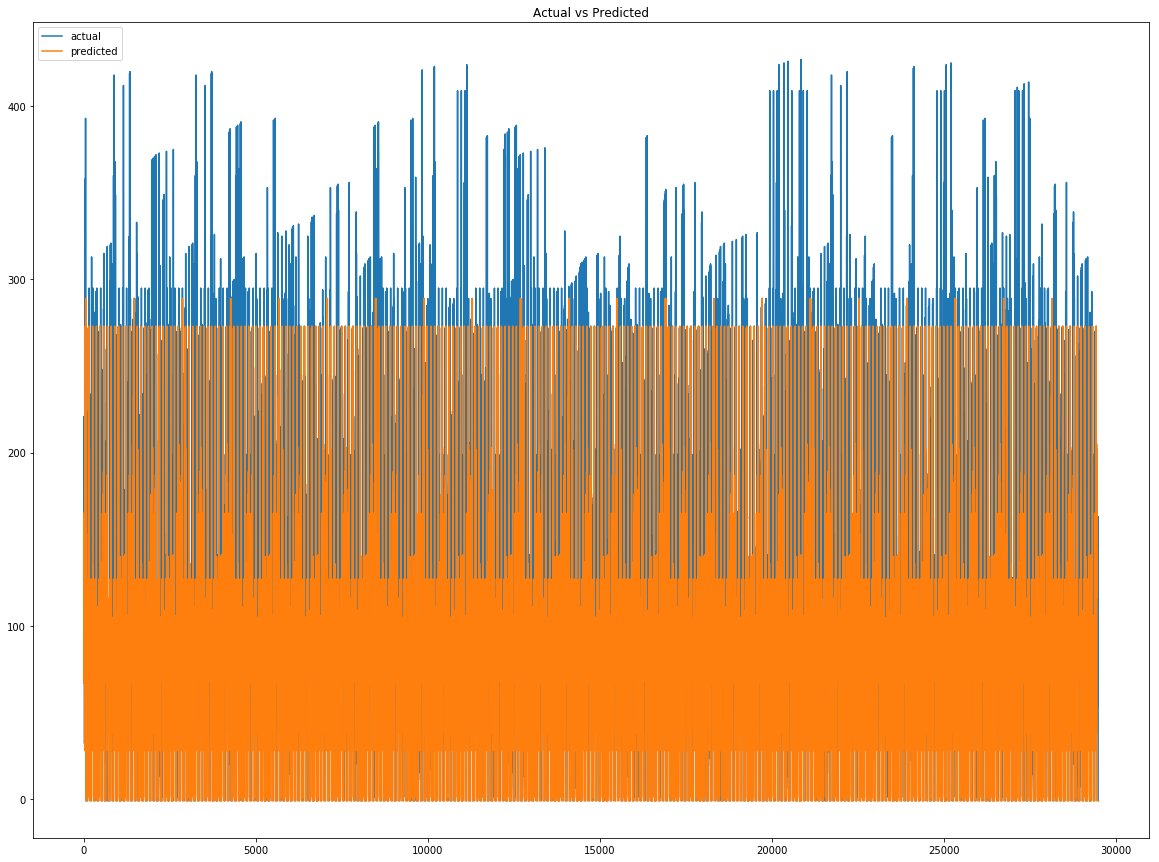

[127 337   1 ...  -1  -1  -1]
[127. 165.  67. ...  -1.  -1.  -1.]
Accuracy [0.3074009324009324]
FScore [0.014748084674000192]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


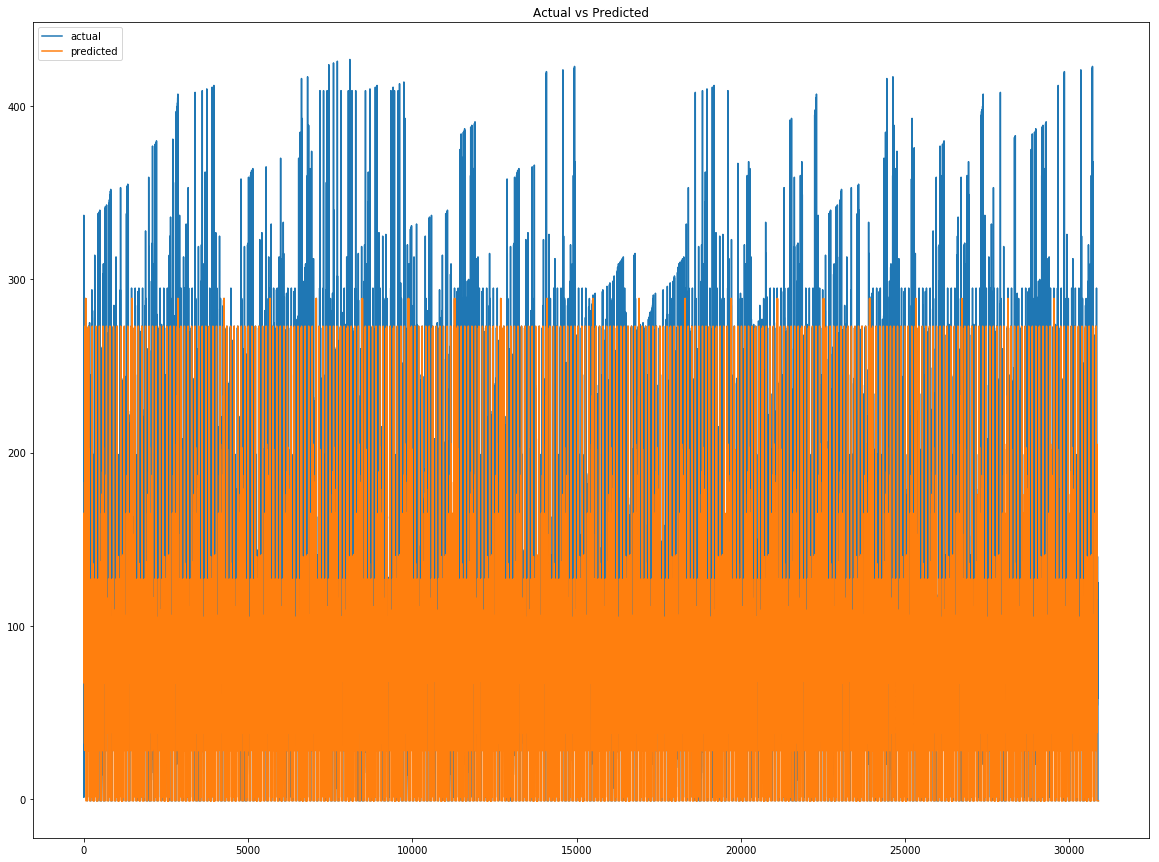

Wall time: 20min 24s


In [42]:
%%time
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
y_validate = y_validate.values
X_test = X_test.values
y_test = y_test.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)) + "\n------------------------------")

# Train on discrete data (Train > Validation)
model = RandomForest(mode='classification',
                     n_estimators=n_estimators,  # Use 2* the number of features
                     parallel_degree=parallel_degree,
                     max_depth=max_depth,
                     lag=lag,
                     max_features=max_features)
model.fit_model(X=X_train,
                y=y_train)

yhat = []
for i in range(0, X_validate.shape[0]):
    X = np.array([X_validate[i,:]])
    y = model.predict(X)
    model.fit_model(X=X,
                    y=y)  # Online Learning, Training on validation predictions.
    yhat.extend(y)    
model.evaluate(y=y_validate,
               yhat=np.array(yhat),
               plot=True)

yhat = []
for i in range(0, X_test.shape[0]):
    X = np.array([X_test[i,:]])
    y = model.predict(X)
    model.fit_model(X=X,
                    y=y)  # Online Learning, Training on testing predictions.
    yhat.extend(y)    
model.evaluate(y=y_test,
               yhat=np.array(yhat),
               plot=True)